In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Midterm 3

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import platform
import sys

from numpy.random import seed

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#set a seed
tf.random.set_seed(42)
seed(42)

First of all, I defined some helper functions: <br>
*load_dataset* loads the CIFAR-10 data, splits the training data into a validation set, and returns training, validation, and test set. <br>
*preprocessing* scales the pixels on each image in CIFAR-10. <br>
*plot_curves* plots the learning curves on training phase.<br>
*plot_heatmap* plots a heatmap from a confusion matrix.<br>
*text_heatmap* writes on the heatmap the quantities of the confusion matrix.

In [4]:
'''
load_dataset
'''
def load_dataset():
    # load dataset
    (trainX, trainY), (X_test, y_test) = cifar10.load_data()
    
    #split training in validation set
    X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.25)

    # apply one-hot encoding on target values
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
'''
preprocessing
args: train - training data
      val - validation data
      test - test data
'''
def preprocessing(train, val, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    val_norm = val.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize
    train_norm = train_norm / 255.0
    val_norm = val_norm / 255.0
    test_norm = test_norm / 255.0

    # return normalized images
    return train_norm, val_norm, test_norm

In [6]:
'''
plot_curves
args: history - record of training loss values and metrics values 
'''
def plot_curves(history):    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # plot loss
    ax.set_title('Cross Entropy Loss')
    ax.plot(history.history['loss'], color='blue', label='Train')
    ax.plot(history.history['val_loss'], color='red', label='Validation')
    ax.legend()

    # plot accuracy
    ax2.set_title('Classification Accuracy')
    ax2.plot(history.history['accuracy'], color='blue', label='Train')
    ax2.plot(history.history['val_accuracy'], color='red', label='Validation')
    ax2.legend()

In [7]:
'''
plot_heatmap
args: data - the confusion matrix
      labels - label classes
      ax - array of axes to plot
      cbar_kw - color bars
      title_hm - title of heatmap 
'''
def plot_heatmap(data, labels, ax=None, cbar_kw={}, title_hm="", **kwargs):
    # plot the heatmap
    im = ax.imshow(data, **kwargs)

    # create the colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(title_hm, rotation=-90, va="bottom")

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

'''
text_heatmap
args: im - image of heatmap
      data - data of confusion matrix
      threshold - threshold that defines color change
'''
def text_heatmap(im, data=None, threshold=None):
  
    # change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], "d"), horizontalalignment="center",
                                 color="white" if data[i, j] > threshold else "black")
            texts.append(text)

    return texts

This function defines the architecture of CNN, to implement this network I follow the tips of the following paper: https://arxiv.org/pdf/1409.1556.pdf. In this paper is about developing a very deep convolutional network to solve an image recognition task.
The paper recommends involving stacking convolutional layers with small 3×3 filters followed by a max-pooling layer with a 2 × 2 pixel window, with stride 2. Each block is increased with the depth of the network (32, 64, 128...) and uses a *ReLU* activation function. <br>
In my own convolutional network, I applied a dropout regularization to reduce the overfitting and applied a SGD optimizer with a *0.0005* learning rate and momentum equal to *0.9*. Moreover, I created *3* blocks for convolutional part.
With this configuration, I obtained a good performance for my neural network without data augmentation. I also added batch normalization in an effort to stabilize the learning.

In [8]:
# define cnn model
def create_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32,  (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [9]:
# load dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
# prepare data
X_train, X_val, X_test = preprocessing(X_train, X_val, X_test)

# define model
model = create_CNN()
# set an early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.summary()

170508288/170498071 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:
# fit model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[callback])

Epoch 1/200
586/586 [==============================] - 20s 12ms/step - loss: 2.3493 - accuracy: 0.2805 - val_loss: 1.5651 - val_accuracy: 0.4372
Epoch 2/200
586/586 [==============================] - 7s 11ms/step - loss: 1.7454 - accuracy: 0.3891 - val_loss: 1.4474 - val_accuracy: 0.4755
Epoch 3/200
586/586 [==============================] - 6s 10ms/step - loss: 1.5463 - accuracy: 0.4487 - val_loss: 1.4321 - val_accuracy: 0.4814
Epoch 4/200
586/586 [==============================] - 7s 12ms/step - loss: 1.4230 - accuracy: 0.4874 - val_loss: 1.2913 - val_accuracy: 0.5425
Epoch 5/200
586/586 [==============================] - 7s 11ms/step - loss: 1.3261 - accuracy: 0.5240 - val_loss: 1.2242 - val_accuracy: 0.5571
Epoch 6/200
586/586 [==============================] - 6s 11ms/step - loss: 1.2570 - accuracy: 0.5533 - val_loss: 1.1786 - val_accuracy: 0.5838
Epoch 7/200
586/586 [==============================] - 7s 11ms/step - loss: 1.1971 - accuracy: 0.5702 - val_loss: 1.2019 - val_accuracy

After various experiments and different CNN architectures, I noticed that validation loss didn't decrease below a certain threshold equal to *0.5*. 

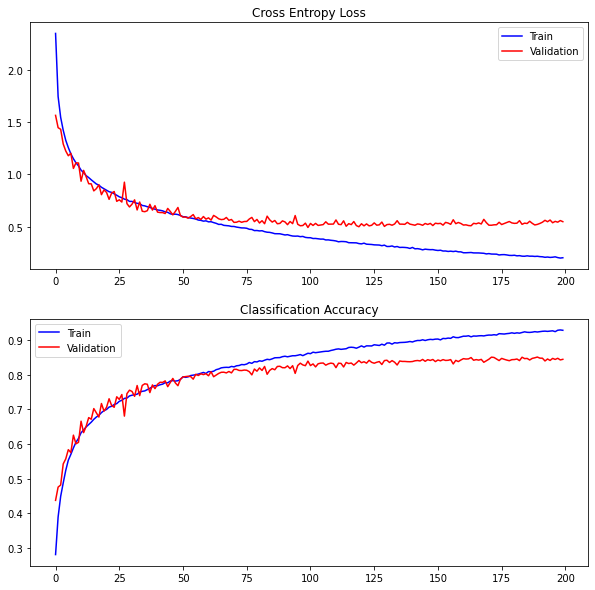

In [11]:
# plot learning curves
plot_curves(history)

In general, we see that CNN has classified the various images pretty well. In the heatmap, we can see that the model has more misclassified prediction with *Cat* and *Dog*, especially, the network struggles to recognize a cat with dog and vice versa. In addition, we can notice that *Bird* class has many missclassified cases with the respect to the other classes.

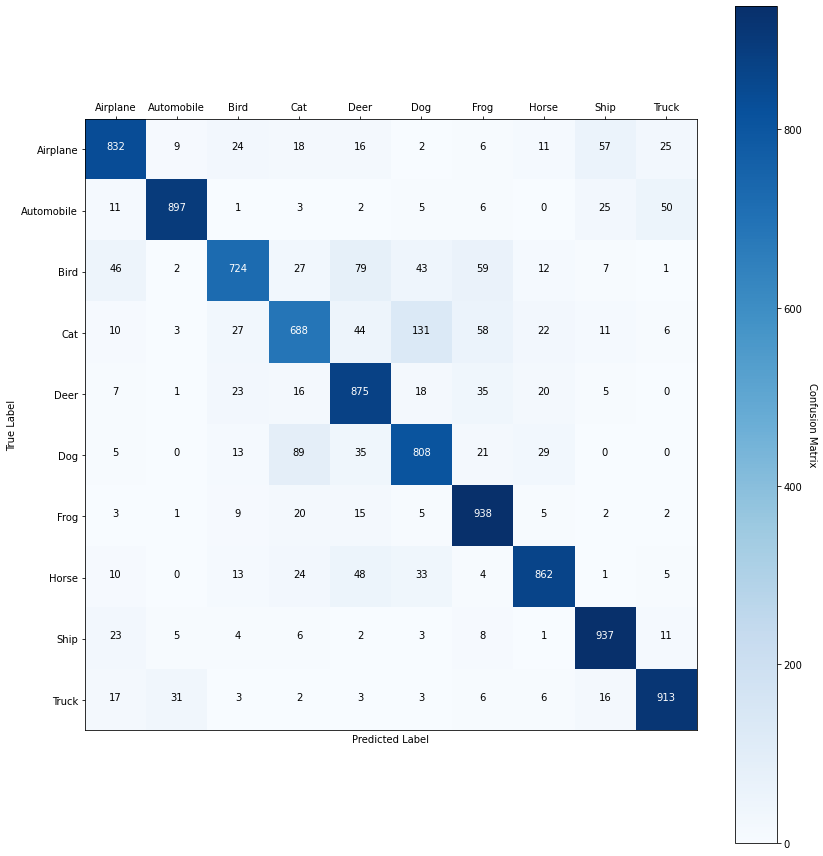

In [12]:
labels_class = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# make predictions
pred = model.predict(X_test)
# one hot enconding on predictions classes
Y_pred_classes = np.argmax(pred, axis=1) 
# one hot enconding on test label
Y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes) 

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = plot_heatmap(cm, labels_class, ax=ax,
                   cmap=plt.cm.Blues, title_hm="Confusion Matrix")
# add text on heatmap
texts = text_heatmap(im, data=cm, threshold=cm.max() / 2.)

fig.tight_layout()
plt.show()

The classification report confirms as said previously. *Cat* and *Dog* classes have a lower F1 score than other classes, in particular, *Cat* has a low precision and recall. The *Bird* class has low recall as well. <br>
In any case, the total accuracy gained by the model is about **0.85** with this configuration.

In [13]:
print(classification_report(Y_true, Y_pred_classes, target_names=labels_class))

              precision    recall  f1-score   support

    Airplane       0.86      0.83      0.85      1000
  Automobile       0.95      0.90      0.92      1000
        Bird       0.86      0.72      0.79      1000
         Cat       0.77      0.69      0.73      1000
        Deer       0.78      0.88      0.83      1000
         Dog       0.77      0.81      0.79      1000
        Frog       0.82      0.94      0.88      1000
       Horse       0.89      0.86      0.88      1000
        Ship       0.88      0.94      0.91      1000
       Truck       0.90      0.91      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



I took the indexes of correct predictions and incorrect predictions, useful for creating some adversarial examples. 

In [14]:
index_correct = []
index_incorrect = []

for i in range(Y_pred_classes.shape[0]):
  if(Y_pred_classes[i] == Y_true[i]):
    index_correct.append(i)
  else:
    index_incorrect.append(i)

### Adversarial attack
In this section, I implemented an adversarial attack with Fast Gradient Sign method. <br>
*create_adv_pattern* creates a perturbation which will be used to distort the original image. Indeed, the FGS method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss.

In [15]:
'''
create_adv_pattern
args: img - image used to create the adversarial pattern
      label - label that correspond to image
'''
def create_adv_pattern(img, label):
    img_tf = tf.cast(img, tf.float32)

    # define categorical cross entropy
    cc_loss = tf.keras.losses.CategoricalCrossentropy()
    
    with tf.GradientTape() as tape:
        tape.watch(img_tf)
        prediction = model(img_tf)
        pred = tf.reshape(prediction, [-1])
        loss = cc_loss(label, pred) 

    gradient = tape.gradient(loss, img_tf)  
    signed_grad = tf.sign(gradient)
    
    return signed_grad

*plot_adv_example* shows visually the original image, adversarial noise, and the adversarial image with the respective labels and confidences.

In [16]:
'''
plot_adv_example
args: real_img - original image
      noise - adversarial noise
      adv_img - adversarial image
      conf_real - confidence to original confidence 
      conf_noise - confidence to noise 
      conf_adv -  confidence to adversarial image
      label_real - original image label
      label_noise - label noise
      label_adv - adversarial image label
      eps - epsilon 
'''
def plot_adv_example(real_img, noise, adv_img, conf_real, conf_noise, conf_adv, label_real, label_noise, label_adv, eps):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    
    fig.suptitle("Epsilon: %.4f" % eps)
    axs[0].imshow(real_img.reshape((32, 32, 3)))
    axs[0].set_title('Label: ' + label_real + ' Confidence: %.4f' %conf_real)
    axs[1].imshow(noise.reshape((32, 32, 3)))
    axs[1].set_title('Label: ' + label_noise + ' Confidence: %.4f' %conf_noise)
    axs[2].imshow(adv_img.reshape((32, 32, 3)))
    axs[2].set_title('Label: ' + label_adv + ' Confidence: %.4f' %conf_adv)

    for ax in axs.flat:
        ax.label_outer()
    plt.show()

*adv_attacks_generator* generates an adversarial perturbation and applies different epsilon to an adversarial image showing the results.

In [17]:
'''
adv_attacks_generator
args: img - image to apply adversarial attack
      label - label that correspond to image
'''
def adv_attacks_generator(img, label):
  noise_adv = create_adv_pattern(img.reshape((1, 32, 32, 3)), label).numpy()

  print("Adversarial noise")
  plt.imshow(noise_adv.reshape((32, 32, 3))) 
  plt.show()

  # plot the adversarial example with different epsilon
  for epsilon in [0.0, 0.0002, 0.001, 0.01, 0.025, 0.05, 0.1, 0.15]:
    noise_adv_eps = epsilon * noise_adv
    adv_img = img + noise_adv_eps

    # make prediction on real image, adversarial noise and advasarial image
    pred_true = model.predict(img.reshape((1, 32, 32, 3)))
    pred_noise = model.predict(noise_adv_eps)
    pred_adv = model.predict(adv_img)

    # get confidences
    confidence_true = np.amax(pred_true)
    confidence_noise = np.amax(pred_noise)
    confidence_adv = np.amax(pred_adv)

    # get labels
    label_true = labels_class[pred_true.argmax()]
    label_noise = labels_class[pred_noise.argmax()]
    label_adv = labels_class[pred_adv.argmax()]

    plot_adv_example(img, noise_adv_eps, adv_img, confidence_true, confidence_noise, confidence_adv, label_true, label_noise, label_adv, epsilon)

I chose some correct predictions to create some adversarial examples to fool the network. In this case, I chose different classes for observing the different effect on the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial noise


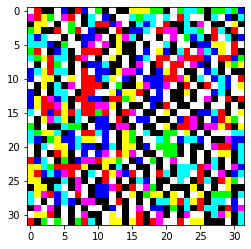

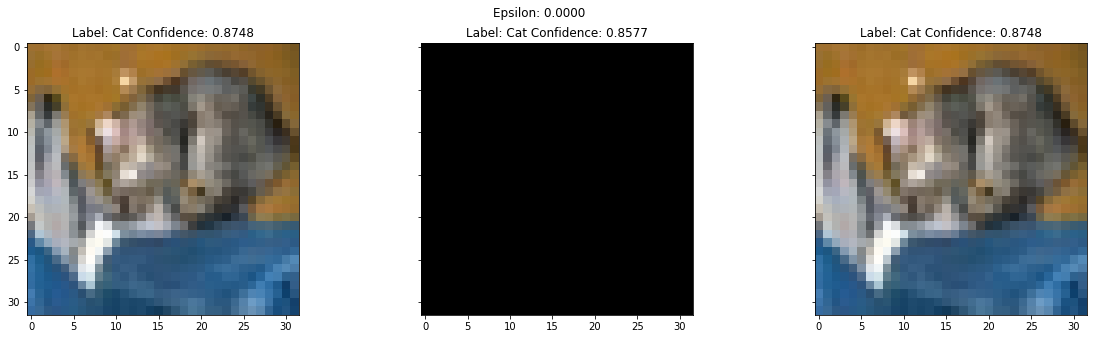

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


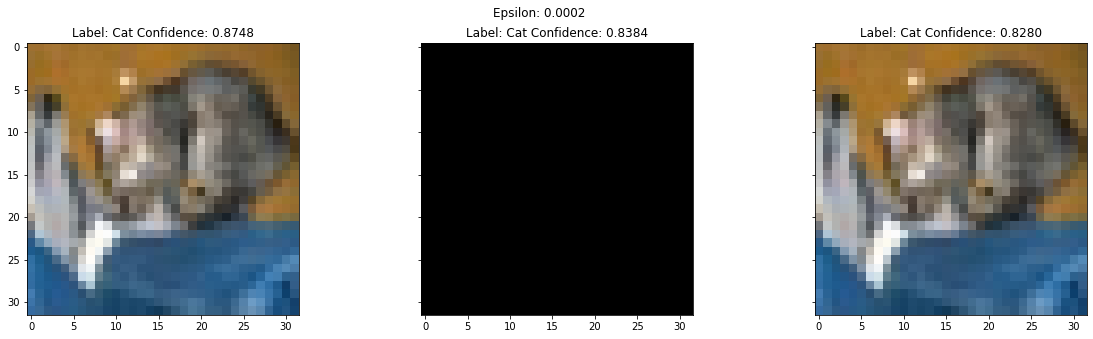

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


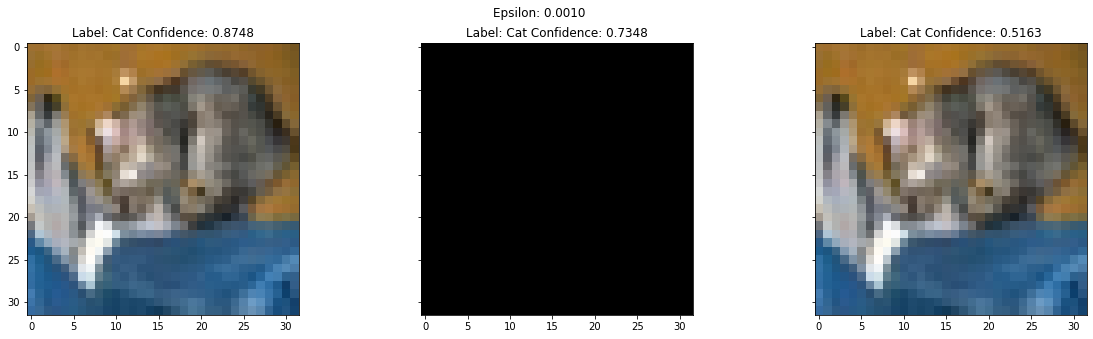

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


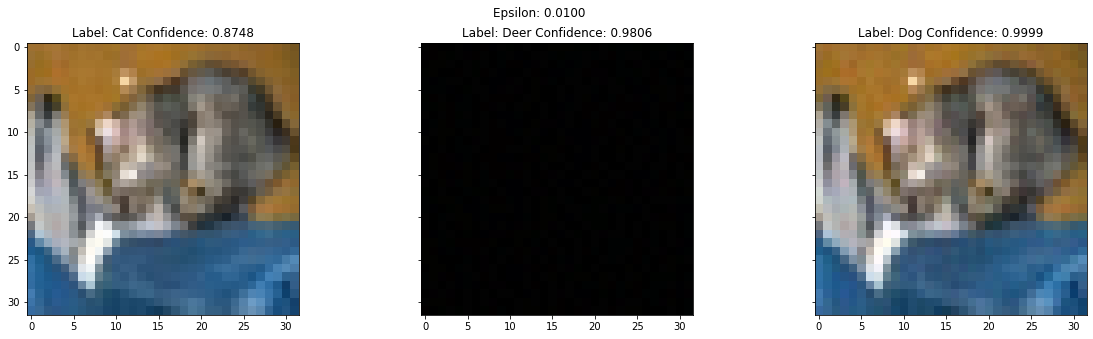

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


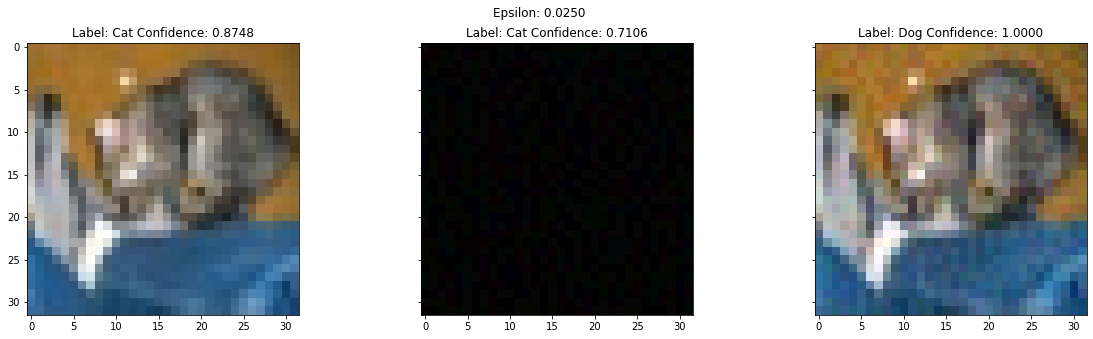

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


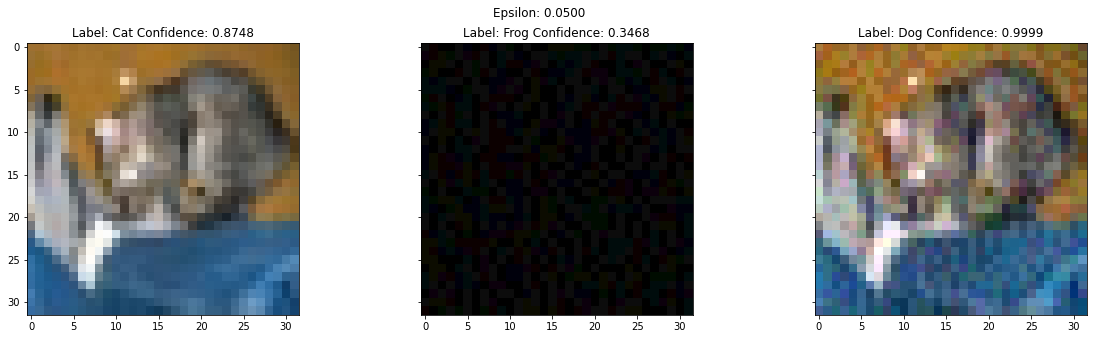

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


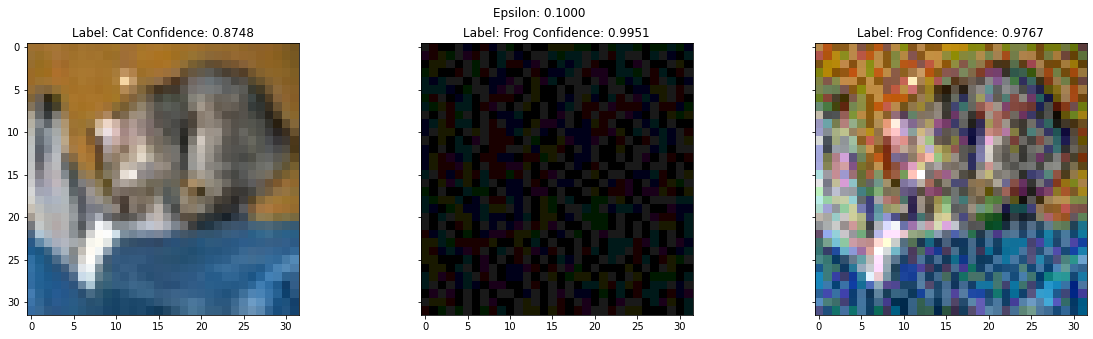

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


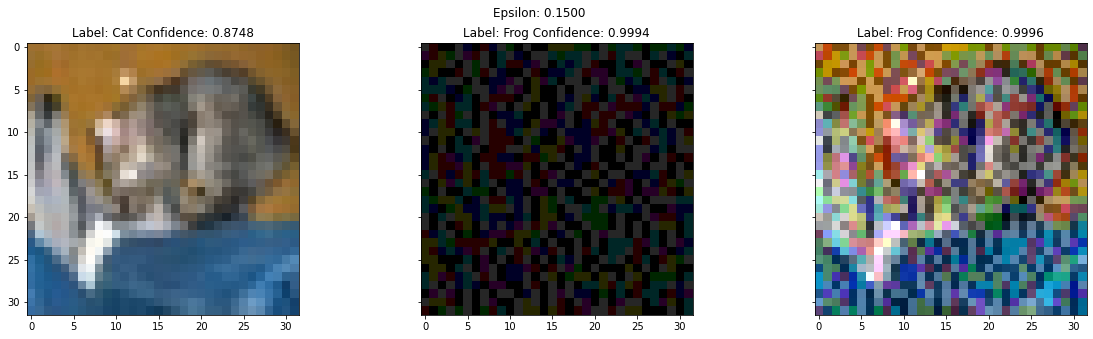

In [18]:
adv_attacks_generator(X_test[index_correct[0]], y_test[index_correct[0]])

In this example, we see as epsilon increases the *Cat* confidence decreases until the model misclassifies completely with high confidence the original image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial noise


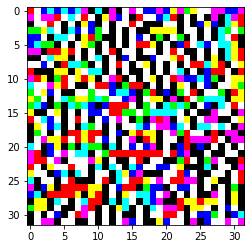

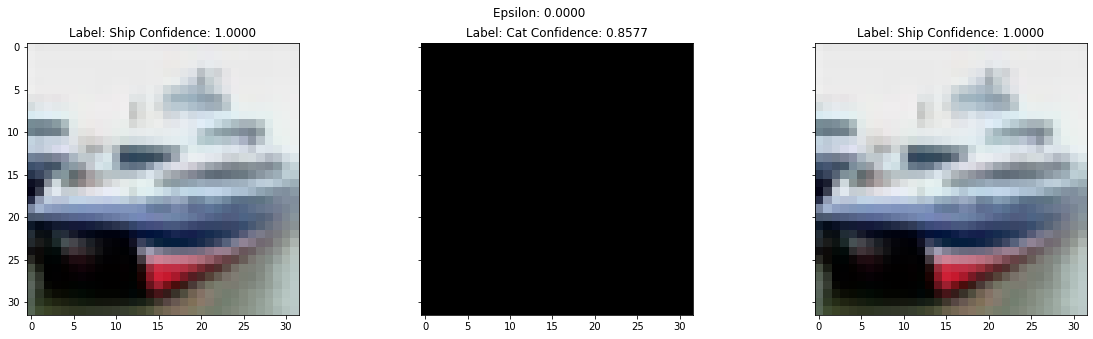

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


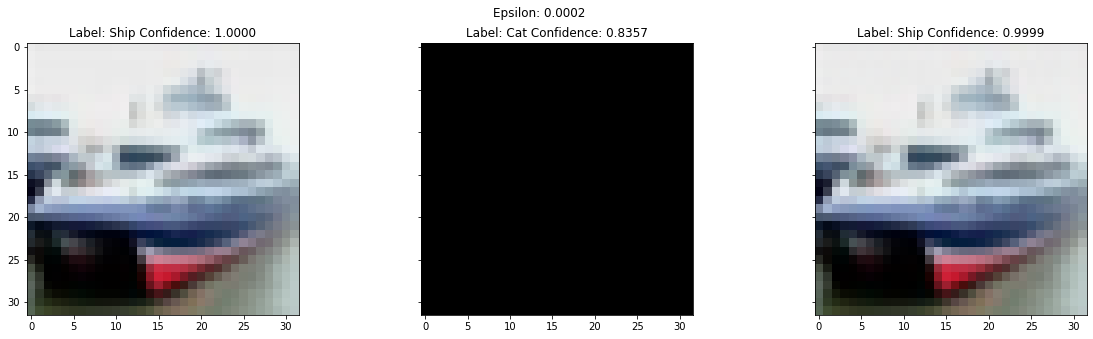

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


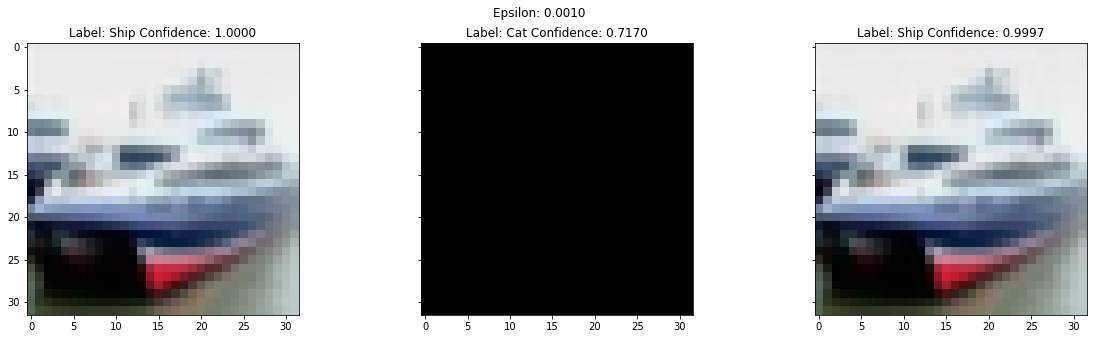

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


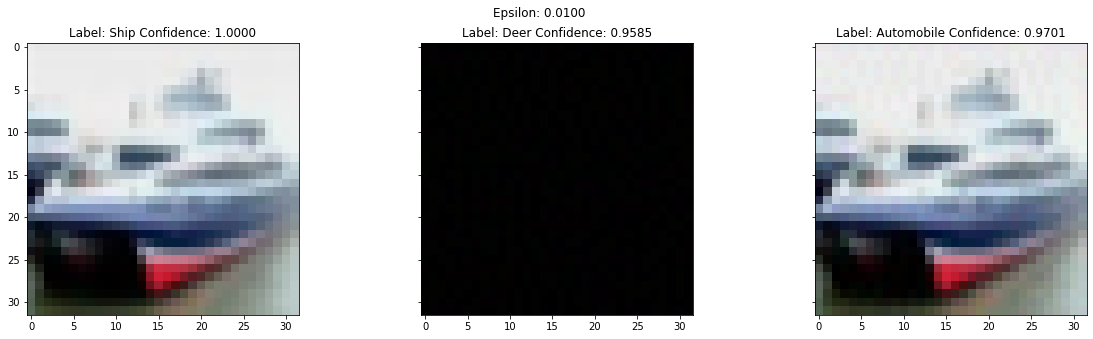

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


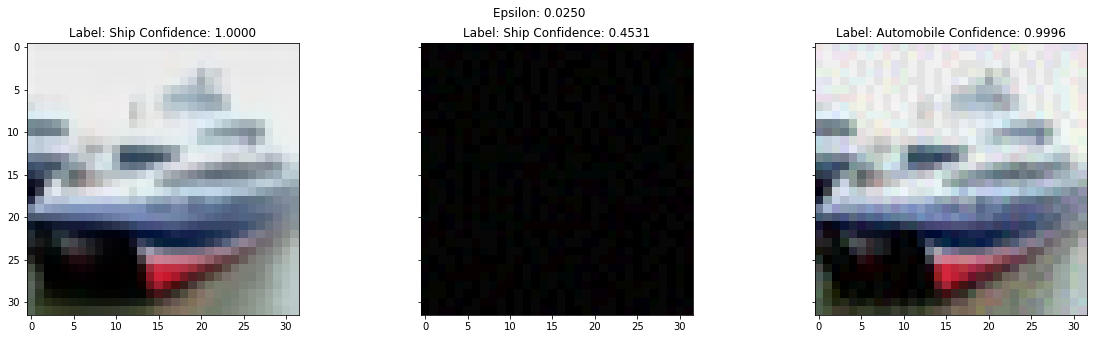

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


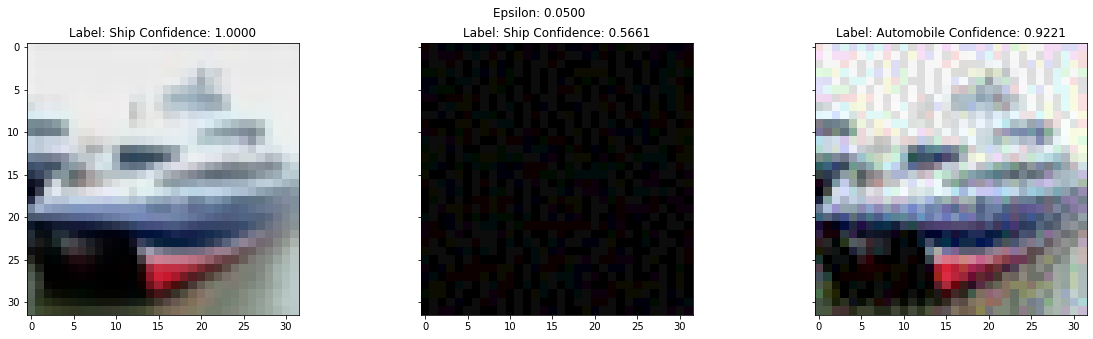

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


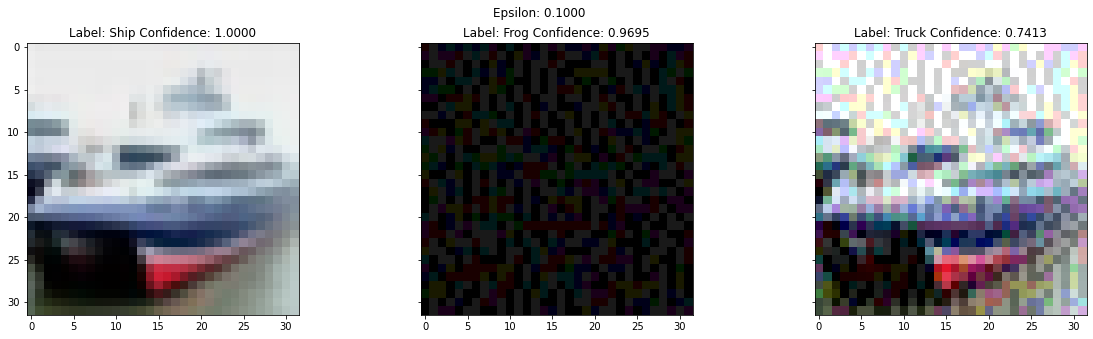

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


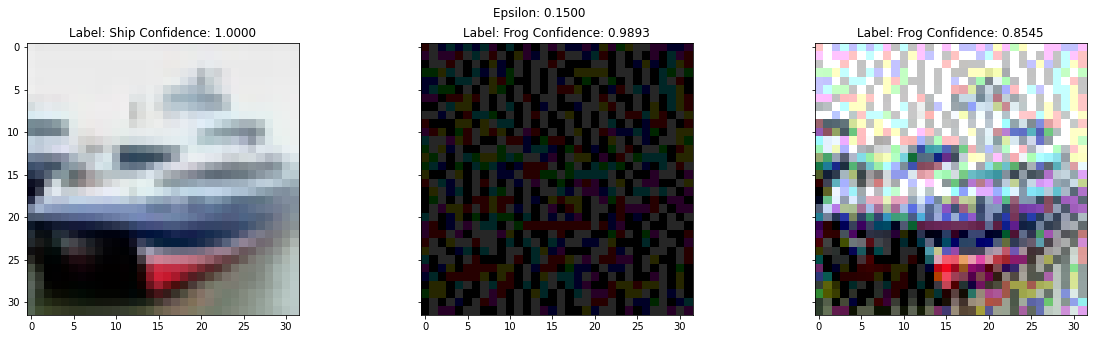

In [19]:
adv_attacks_generator(X_test[index_correct[1]], y_test[index_correct[1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial noise


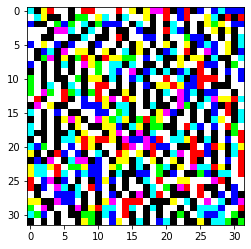

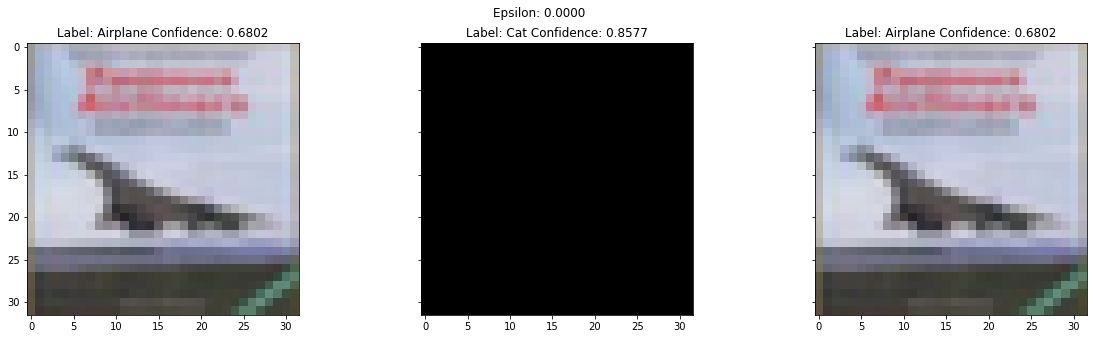

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


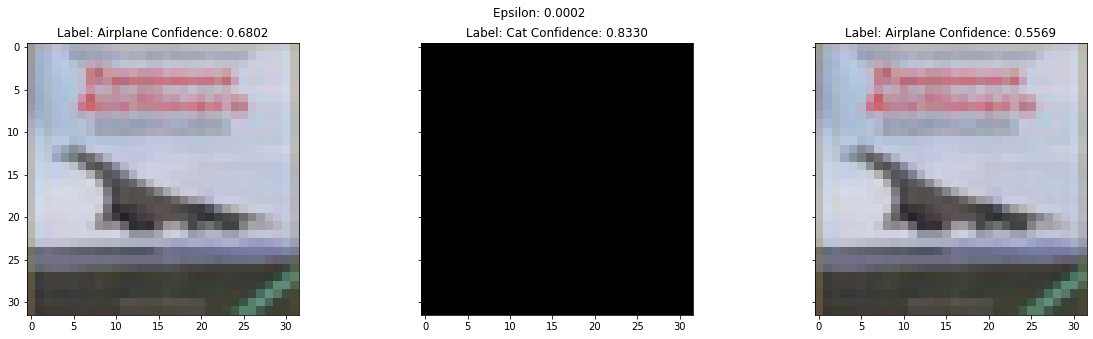

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


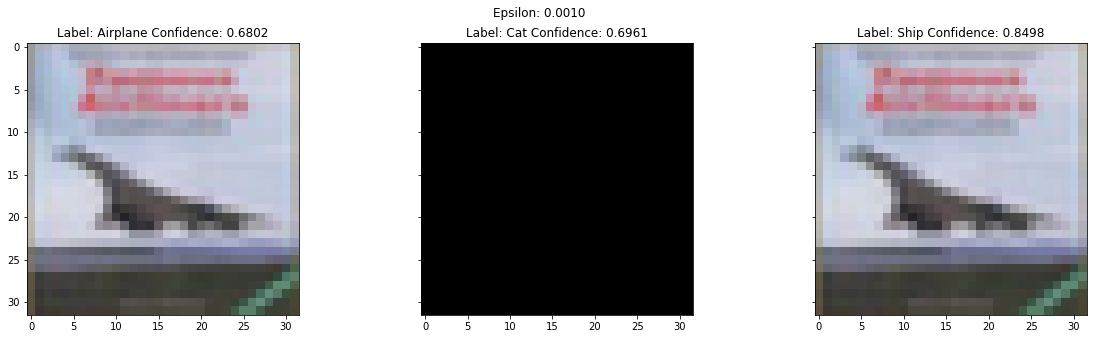

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


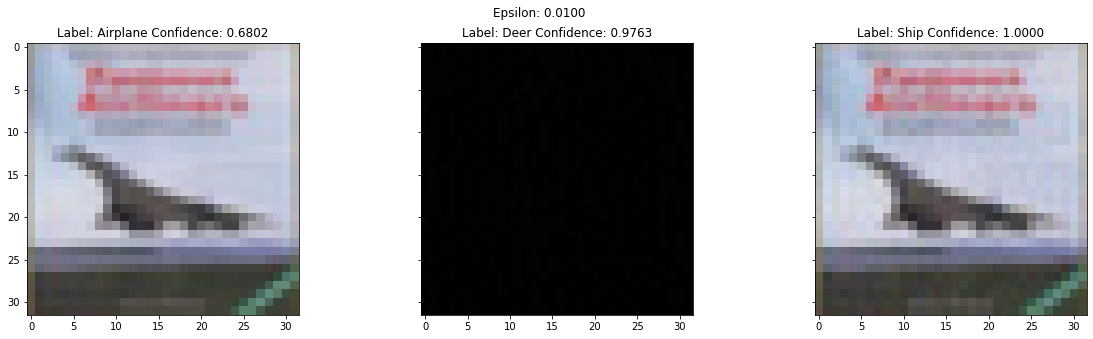

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


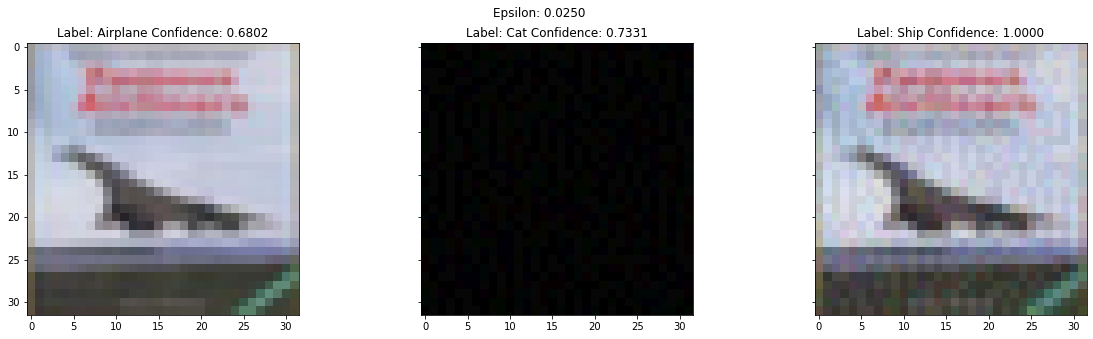

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


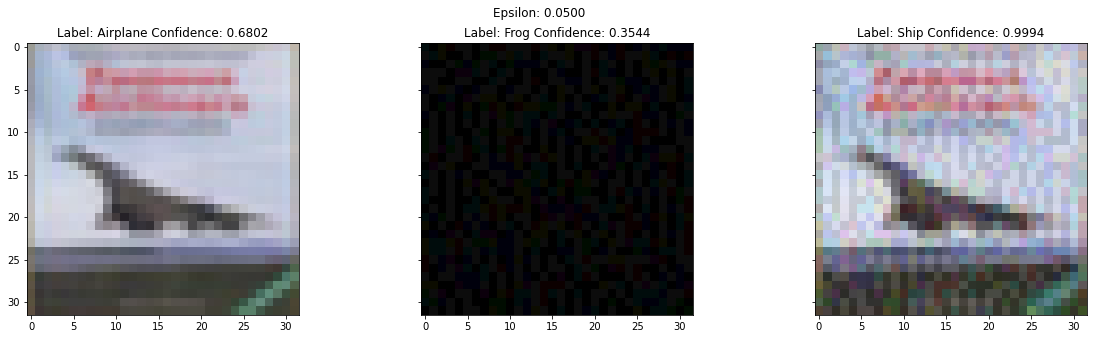

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


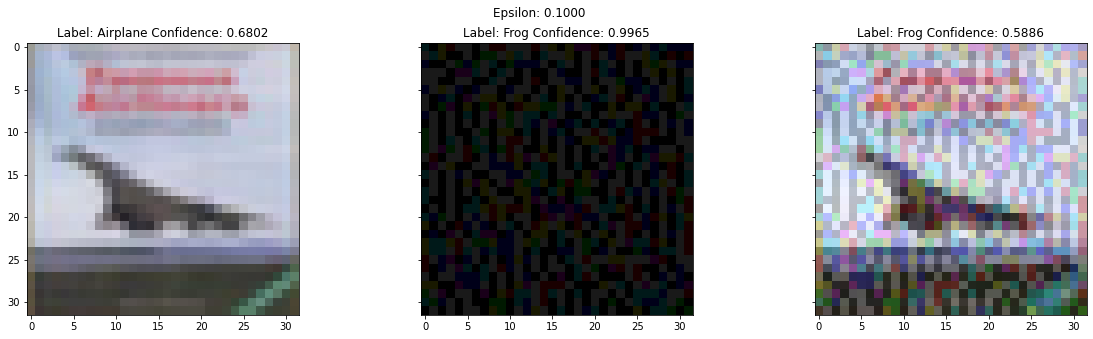

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


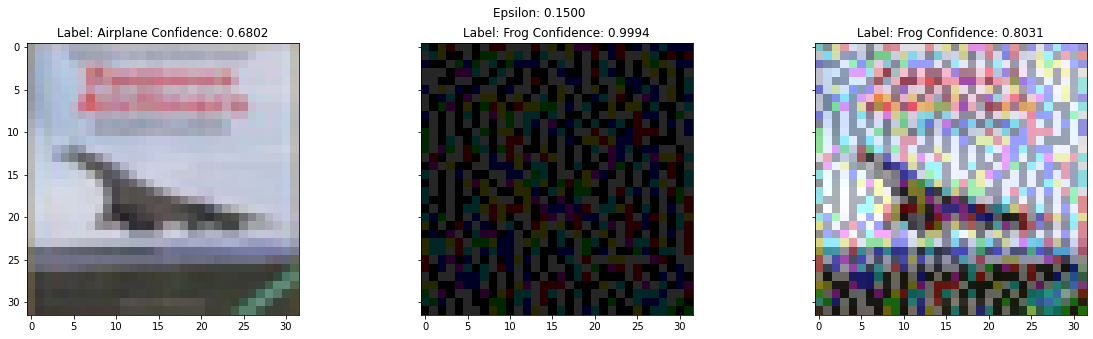

In [20]:
adv_attacks_generator(X_test[index_correct[3]], y_test[index_correct[3]])

For just curiosity, I used as an example a wrong prediction, obviously, the adversarial attack changes little the classification.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial noise


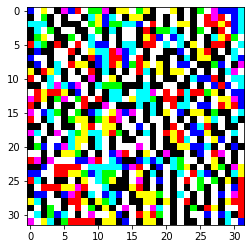

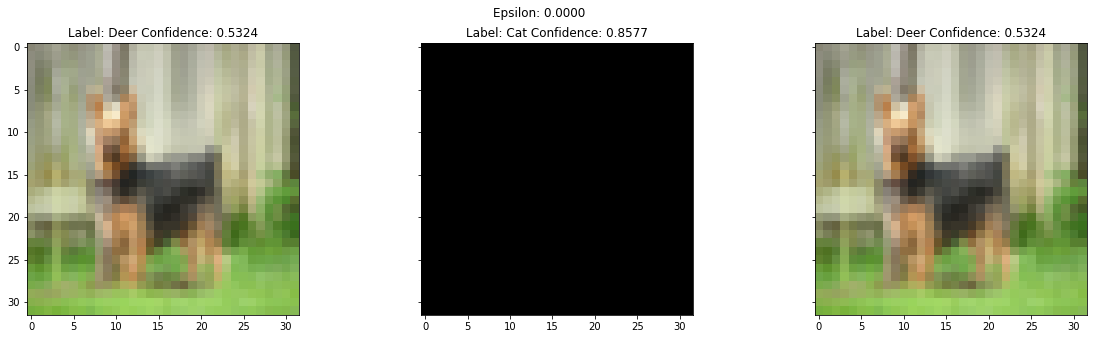

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


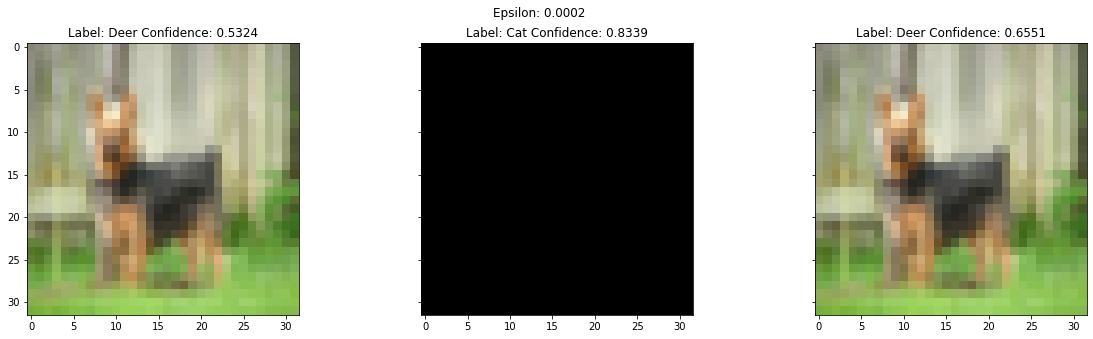

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


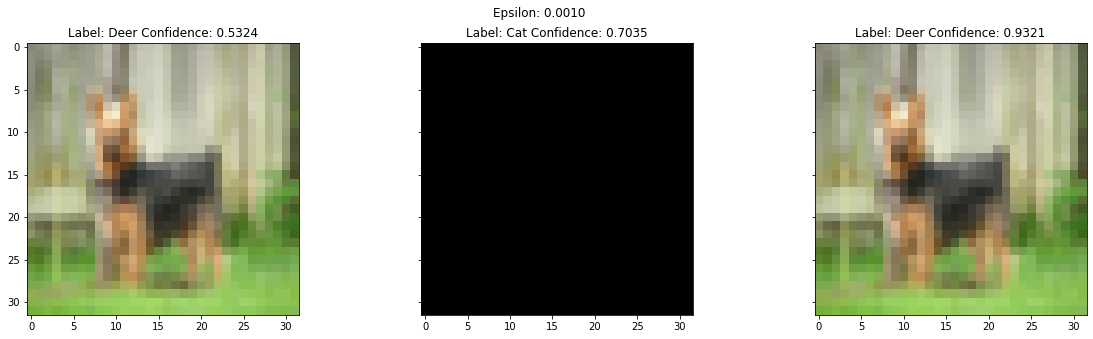

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


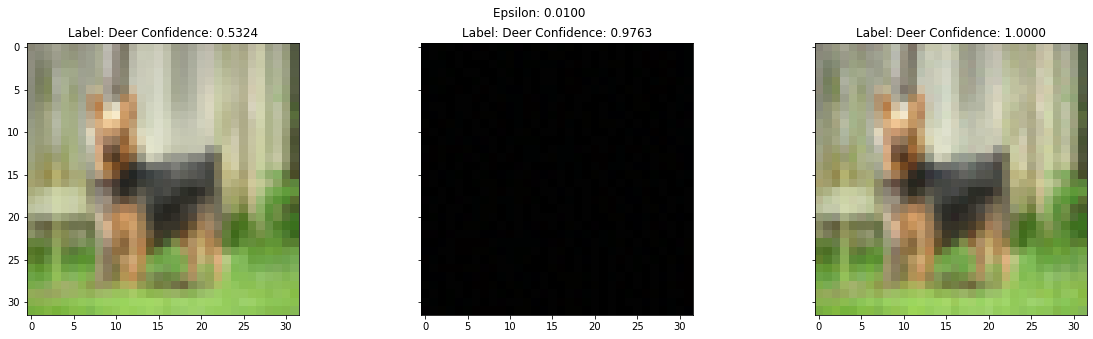

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


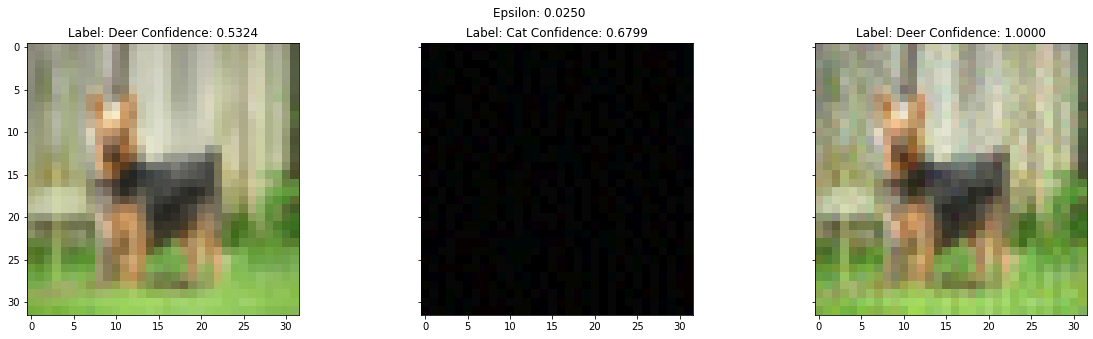

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


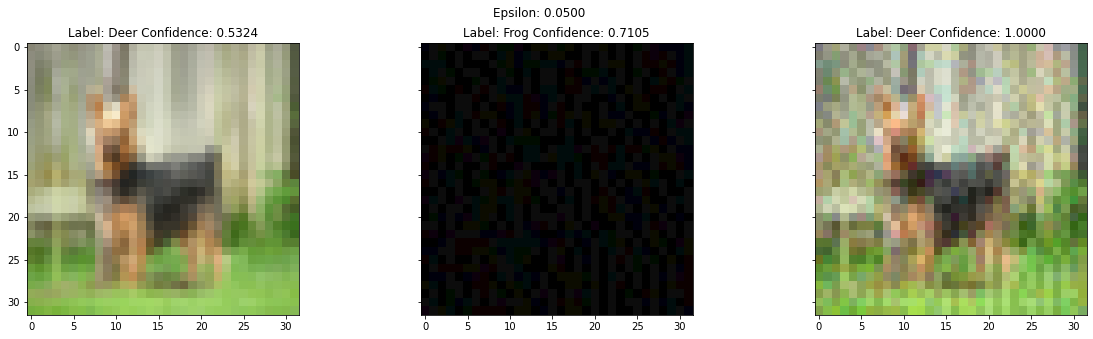

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


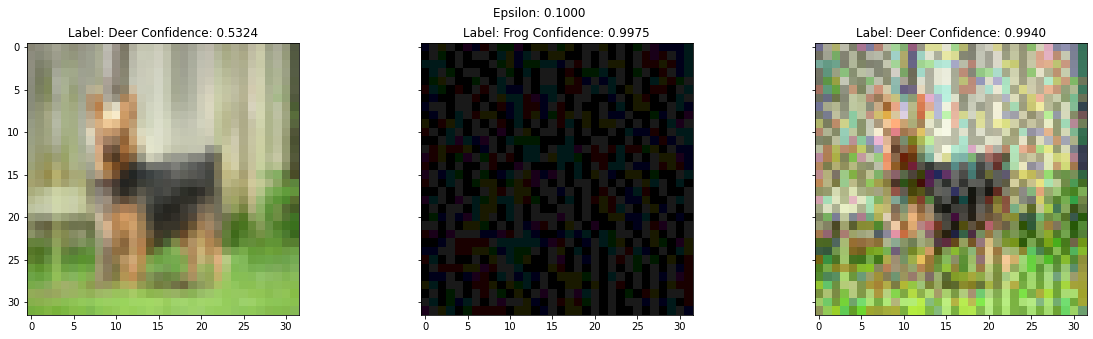

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


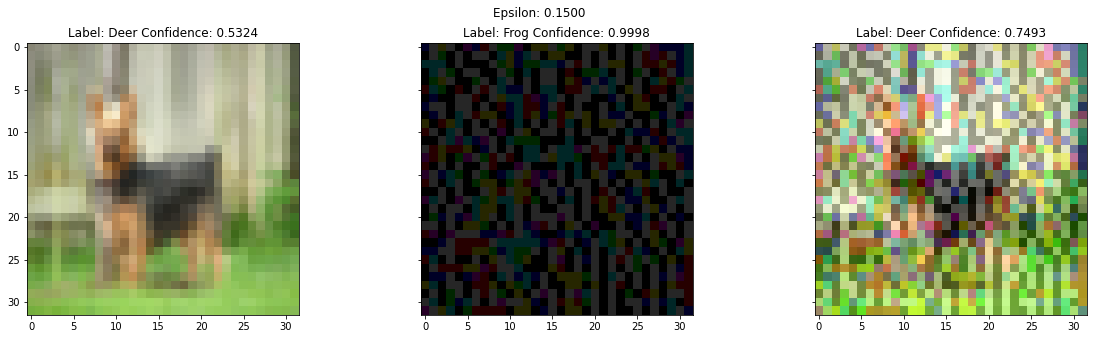

In [21]:
adv_attacks_generator(X_test[index_incorrect[0]], y_test[index_incorrect[0]])

### Considerations
For this task, I trained my own CNN and I tested different configurations for my model reaching *85%* of accuracy. But I believe using the data augmentation, changing some dropout parameters, and adding some convolutional blocks, I could increase a little the accuracy of my model.
As for the adversarial attack, as we thought, it can fool a neural network; indeed, the FGSM allows us to do this. Moreover, the epsilon mitigates the adversarial noise, indeed with a low epsilon the noise is light; on the contrary, if the epsilon is high, the effect of the adversarial attack is greater.
During the experiments, a curious fact is that the network often recognizes the noise as *Frog* or *Cat*, especially with a high epsilon applied to example image effects so that the model classifies the adversarial image as a *Frog*.